In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import imutils
import easyocr

import os

In [2]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4  # Non-maximum suppression threshold

inpWidth = 416  # 608     # Width of network's input image
inpHeight = 416  # 608     # Height of network's input image

In [5]:
# Load names of classes
classesFile = "yolo-license-plate-detection/model/classes.names"

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolo-license-plate-detection/model/config/darknet-yolov3.cfg"
modelWeights = "yolo-license-plate-detection/model/weights/model.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [6]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    #    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 7)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s: %s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(
        label, cv.FONT_HERSHEY_SIMPLEX, 1, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.7*labelSize[1])), (left + round(
        1.3*labelSize[0]), top + baseLine), (255, 0, 255), cv.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top),
               cv.FONT_HERSHEY_SIMPLEX, 1.3, (255, 255, 255), 2)

In [8]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            # if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4] > confThreshold:
                print(detection[4], " - ", scores[classId],
                      " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        # i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left,
                 top, left + width, top + height)

In [15]:
image_dir = 'yolo-license-plate-detection\data'

if not os.path.isdir(image_dir):
    print("Input image dir ", image_dir, " doesn't exist")
for image_name in [k for k in os.listdir(image_dir) if 'out_py' not in k]:
    # os.system('python object_detection_yolo.py --image={}'.format(os.path.join(image_dir, image_path)))
    image_path = os.path.join(image_dir, image_name)
    print(f"Image_path = {image_path}")
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.title(image_name)
    plt.show()
    """

Image_path = yolo-license-plate-detection\data\automobile-1846297_1920.jpg
Image_path = yolo-license-plate-detection\data\automobile-418879_1920.jpg
Image_path = yolo-license-plate-detection\data\cadillac-7304111_1920.jpg
Image_path = yolo-license-plate-detection\data\car-6122177_1920.jpg
Image_path = yolo-license-plate-detection\data\car-6366999_1920.jpg
Image_path = yolo-license-plate-detection\data\ferrari-188954_1920.jpg
Image_path = yolo-license-plate-detection\data\wartburg-2456243_1920.jpg


out.shape :  (507, 6)
0.9705164  -  0.9690628  - th :  0.5
[0.48955134 0.73654175 0.3239403  0.11206077 0.9705164  0.9690628 ]
out.shape :  (2028, 6)
out.shape :  (8112, 6)


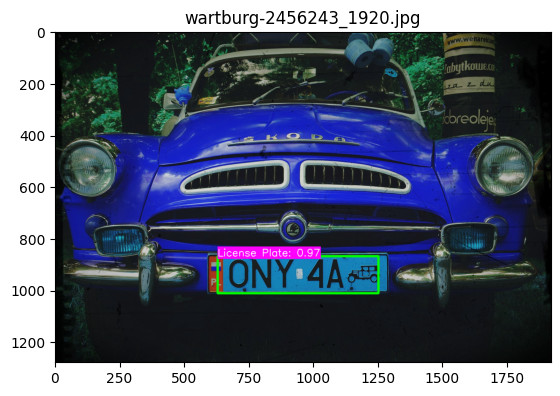

In [18]:
frame = cv2.imread(image_path)

# Create a 4D blob from the frame
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
    
# Set input to the network
net.setInput(blob)

# Run forward pass and get output
outs = net.forward(getOutputsNames(net))

# Remove bounding boxes with low confidence and draw predictions
postprocess(frame, outs)

# Display the resulting frame
plt.imshow(frame)
plt.title(image_name)
plt.show()